# Assessment 3: RNNs for stock price prediction

In [2]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [3]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
import datetime as dt
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


Using device: cpu



## Step01: Data exploration

In [5]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

[22964:MainThread](2023-11-15 18:08:37,711) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[22964:MainThread](2023-11-15 18:08:37,719) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[22964:MainThread](2023-11-15 18:08:37,719) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/possa/.qlib/qlib_data/us_data')}


In [6]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
# index_list  = ['AAPL', 'MSFT']
# index_name  = ['Apple', 'Microsoft']
# index_list  = ['AAPL']
# index_name  = ['Apple']
# fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
def set_df():
    # select the index & Fleids
    index_list  = ['AAPL']
    # index_list  = ['AAPL', 'MSFT']
    fields = ['$close', '$volume', '$open', '$high', '$low']
    
    # download dataset
    df = D.features(index_list , fields, freq='day')
    
    # manipulated the dataset
    df = df.reset_index()
    df.columns = ['symbols','date','close','volume','open','high','low']
    df.date = df.date.dt.date
    print(f"Period since {min(df.date)} to {max(df.date)}: {max(df.date) - min(df.date)}")
    return df, index_list

df, index_list = set_df()

Period since 1999-12-31 to 2020-11-10: 7620 days, 0:00:00


In [7]:
df.tail(5)

,symbols,date,close,volume,open,high,low
5245,AAPL,2020-11-04,146.096085,108765200.0,145.066620,146.909500,142.791611
5246,AAPL,2020-11-05,151.281586,99442752.0,149.908951,152.031448,148.536331
5247,AAPL,2020-11-06,151.109711,89901624.0,150.638641,151.759003,147.850449
5248,AAPL,2020-11-09,148.092346,121364944.0,153.414108,155.311081,147.748611
5249,AAPL,2020-11-10,147.646759,108411280.0,147.112030,149.709244,145.304153


### Exploratory Image analysis

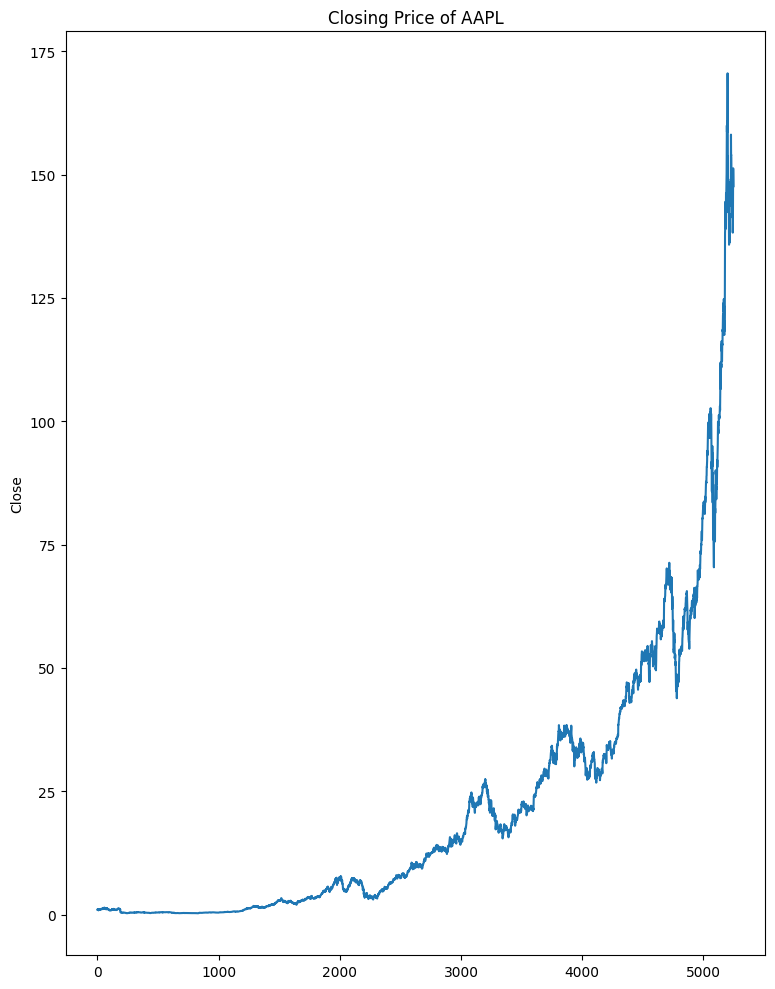

In [8]:
def plot_timeline(df):
# Let's see a historical view of the closing price
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(top=1.25, bottom=1.2)

    for i, company in enumerate(index_list, 1):
        plt.subplot(1, 2, i)
        df.loc[df['symbols'] == index_list[i-1]]['close'].plot()
        plt.ylabel('Close')
        plt.xlabel(None)
        plt.title(f"Closing Price of {index_list[i - 1]}")
        
    plt.tight_layout()
    
plot_timeline(df)

## Step 2: Data Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = df['close'].values
df_scaled = scaler.fit_transform(df_scaled.reshape(-1,1))
df_scaled

array([[0.00437381],
       [0.00489503],
       [0.00435596],
       ...,
       [0.88591343],
       [0.86819357],
       [0.8655768 ]], dtype=float32)

## Step 03: Data splitting

In [10]:
# splitting criteria training 70%, validation 20% and testing 10%
train_size = int(len(df_scaled) * 0.7)
valid_size = int(len(df_scaled) * 0.2)

train_data = df_scaled[:train_size]
valid_data = df_scaled[train_size:train_size + valid_size]
test_data = df_scaled[train_size + valid_size:]

print(f"Training size: {len(train_data)} period {df.date[0]} to {df.date[train_size-1]} \nValidation size: {len(valid_data)} period {df.date[train_size]} to {df.date[train_size + valid_size-1]}\ntest_data size: {len(test_data)} period {df.date[train_size + valid_size]} to {df.date[len(df_scaled)-1]}")

Training size: 3674 period 1999-12-31 to 2014-08-08 
Validation size: 1050 period 2014-08-11 to 2018-10-09
test_data size: 526 period 2018-10-10 to 2020-11-10


In [11]:
def create_dataset(dataset,time_step):
    X,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:i+time_step,0]
        X.append(a)
        y.append(dataset[i+time_step,0])
        
    # #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    X_output = torch.tensor(np.array(X))
    X_output = X_output.reshape(X_output.shape[0],X_output.shape[1],1)
    Y_output = torch.tensor(np.array(y)).unsqueeze(dim=1)
    # return X_output,Y_output
    return torch.utils.data.TensorDataset(X_output, Y_output)

# X_train , y_train = create_dataset(train_data,50)
# X_val, y_val = create_dataset(train_data,50)
# X_train.shape

batch_size = 8
trainloader = torch.utils.data.DataLoader(
    # torch.utils.data.TensorDataset(X_train, y_train), 
    create_dataset(train_data,50),
    shuffle=True, 
    batch_size=batch_size,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    create_dataset(valid_data,50),
    batch_size=batch_size,
    shuffle=False,
    # num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    create_dataset(test_data,50),
    batch_size=batch_size,
    shuffle=False,
    pin_memory = True
    )


## Step 04: Define the RNN Model

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.RNN(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
rnn = RNN(input_size = 1, hidden_size = 32, num_layers = 2,  output_size = 1)
rnn    

RNN(
  (RNN): RNN(1, 32, num_layers=2)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
import torch
import torch.nn as nn

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = StockRNN(input_size=5, hidden_size=10, num_layers=2)

## Step 05: training model

In [14]:
import time
from tqdm import tqdm

## apply the dataloader
set_seed(1311)

def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    
    # Initializing variable
    running_loss = 0.0
    # correct_train = 0
    total_train = 0
    hidden = None
    
    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)
        hidden = hidden.data
        
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        # _, preds = torch.max(outputs, 1)
        # correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)
        
    epoch_loss = running_loss / total_train
    # epoch_acc = correct_train.double() / total_train
    return epoch_loss #, epoch_acc
    
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    # correct = 0
    total = 0
    hidden = None
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, hidden = model(inputs, hidden)
            hidden = hidden.data
            
            # loss = criterion(outputs, labels)
            loss = criterion(outputs.view(-1), labels)
            running_loss += loss.item() * inputs.size(0)
            # _, preds = torch.max(outputs, 1)
            # correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    
    loss = running_loss / total
    # accuracy = correct.double() / total

    # results = (loss, accuracy)
    return loss

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./model/{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_loss = 100000  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'val_loss': [],
    }
    
     ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss = train_epoch(model, trainloader, criterion, optimizer)
        val_loss = evaluate(model, valloader, criterion)

        # Step the scheduler with the validation loss
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        # history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        # history['val_accuracy'].append(100 * val_acc)
        
        # Save the model if it has improved on validation accuracy
        if best_val_loss > val_loss:
            print("check loss: ",best_val_loss,val_loss)
            best_val_loss = val_loss
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')
            
        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')
        
    print('Training complete. Evaluating on test set with the best model...')
    
    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    
    test_loss = evaluate(best_model, testloader, criterion)
    # y_pred, h_State = best_model(torch.tensor(test_data))
    print(f'Test Loss: {test_loss:.4f}')
    # Add test results to history
    history['test_loss'] = test_loss
    history['best_model'] = best_model
    
    return history

In [15]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


In [16]:
from torchsummary import summary
for i in [rnn]:
    print("Model: ", i.__class__.__name__)
    print("Number of parameters: ", sum(p.numel() for p in i.parameters() if p.requires_grad))
    # summary(i.to(device), (3, 32, 32))
    print("-"*50)

Model:  RNN
Number of parameters:  3265
--------------------------------------------------


Model will be saved to: ./model/AAPL_simepleRNN.pth
Using device: cpu with seed: 1311



Training:   0%|          | 0/453 [00:00<?, ?it/s]c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([400])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:  98%|█████████▊| 444/453 [00:02<00:00, 176.23it/s]c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([350])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Evaluating: 100%|██████████| 125/125 [00:00<00:00, 460.42it/s]


check loss:  100000 0.03513020574599057
Model improved and saved to ./model/AAPL_simepleRNN.pth
Epoch 1/200, Train Loss: 0.0025, Val Loss: 0.0351, Time: 3.23s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 595.69it/s]


check loss:  0.03513020574599057 0.03247196195988326
Model improved and saved to ./model/AAPL_simepleRNN.pth
Epoch 2/200, Train Loss: 0.0022, Val Loss: 0.0325, Time: 2.87s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 724.25it/s]


check loss:  0.03247196195988326 0.020676981941148923
Model improved and saved to ./model/AAPL_simepleRNN.pth
Epoch 3/200, Train Loss: 0.0021, Val Loss: 0.0207, Time: 3.00s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 699.56it/s]


check loss:  0.020676981941148923 0.009599373661898994
Model improved and saved to ./model/AAPL_simepleRNN.pth
Epoch 4/200, Train Loss: 0.0021, Val Loss: 0.0096, Time: 2.86s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 592.69it/s]


Epoch 5/200, Train Loss: 0.0020, Val Loss: 0.0282, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 718.61it/s]


Epoch 6/200, Train Loss: 0.0021, Val Loss: 0.0143, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 690.74it/s]


Epoch 7/200, Train Loss: 0.0021, Val Loss: 0.0239, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 598.50it/s]


Epoch 8/200, Train Loss: 0.0021, Val Loss: 0.0149, Time: 2.66s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 818.35it/s]


Epoch 9/200, Train Loss: 0.0021, Val Loss: 0.0116, Time: 2.63s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 777.19it/s]


Epoch 10/200, Train Loss: 0.0021, Val Loss: 0.0162, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 701.05it/s]


Epoch 11/200, Train Loss: 0.0021, Val Loss: 0.0121, Time: 2.82s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 539.58it/s]


Epoch 12/200, Train Loss: 0.0020, Val Loss: 0.0149, Time: 2.66s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 708.53it/s]


Epoch 13/200, Train Loss: 0.0021, Val Loss: 0.0126, Time: 2.57s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 777.53it/s]


Epoch 14/200, Train Loss: 0.0020, Val Loss: 0.0177, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 786.13it/s]


Epoch 15/200, Train Loss: 0.0020, Val Loss: 0.0159, Time: 2.65s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 718.77it/s]


Epoch 16/200, Train Loss: 0.0020, Val Loss: 0.0132, Time: 2.59s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 674.24it/s]


Epoch 17/200, Train Loss: 0.0021, Val Loss: 0.0112, Time: 2.67s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 756.08it/s]


Epoch 18/200, Train Loss: 0.0020, Val Loss: 0.0234, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 757.73it/s]


Epoch 19/200, Train Loss: 0.0020, Val Loss: 0.0302, Time: 2.59s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 684.26it/s]


Epoch 20/200, Train Loss: 0.0020, Val Loss: 0.0203, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 728.55it/s]


Epoch 21/200, Train Loss: 0.0021, Val Loss: 0.0241, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 707.28it/s]


Epoch 22/200, Train Loss: 0.0020, Val Loss: 0.0283, Time: 2.67s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 652.15it/s]


Epoch 23/200, Train Loss: 0.0020, Val Loss: 0.0284, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 750.40it/s]


Epoch 24/200, Train Loss: 0.0020, Val Loss: 0.0325, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 684.40it/s]


Epoch 25/200, Train Loss: 0.0020, Val Loss: 0.0269, Time: 2.66s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 740.21it/s]


Epoch 26/200, Train Loss: 0.0021, Val Loss: 0.0260, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 557.58it/s]


Epoch 27/200, Train Loss: 0.0020, Val Loss: 0.0265, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 666.25it/s]


Epoch 28/200, Train Loss: 0.0020, Val Loss: 0.0308, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 728.16it/s]


Epoch 29/200, Train Loss: 0.0020, Val Loss: 0.0385, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 639.62it/s]


Epoch 30/200, Train Loss: 0.0020, Val Loss: 0.0262, Time: 2.76s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 713.72it/s]


Epoch 31/200, Train Loss: 0.0020, Val Loss: 0.0280, Time: 2.70s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 736.61it/s]


Epoch 32/200, Train Loss: 0.0020, Val Loss: 0.0265, Time: 2.70s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 685.74it/s]


Epoch 33/200, Train Loss: 0.0020, Val Loss: 0.0337, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 690.43it/s]


Epoch 34/200, Train Loss: 0.0020, Val Loss: 0.0256, Time: 2.73s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 592.18it/s]


Epoch 35/200, Train Loss: 0.0020, Val Loss: 0.0262, Time: 3.00s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 556.01it/s]


Epoch 36/200, Train Loss: 0.0020, Val Loss: 0.0244, Time: 2.99s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 705.22it/s]


Epoch 37/200, Train Loss: 0.0020, Val Loss: 0.0234, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 684.25it/s]


Epoch 38/200, Train Loss: 0.0020, Val Loss: 0.0339, Time: 2.61s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 730.42it/s]


Epoch 39/200, Train Loss: 0.0020, Val Loss: 0.0268, Time: 2.60s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 710.77it/s]


Epoch 40/200, Train Loss: 0.0020, Val Loss: 0.0278, Time: 2.54s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 741.39it/s]


Epoch 41/200, Train Loss: 0.0020, Val Loss: 0.0267, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 794.25it/s]


Epoch 42/200, Train Loss: 0.0020, Val Loss: 0.0307, Time: 2.55s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 819.33it/s]


Epoch 43/200, Train Loss: 0.0020, Val Loss: 0.0308, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 747.09it/s]


Epoch 44/200, Train Loss: 0.0020, Val Loss: 0.0270, Time: 2.41s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 739.89it/s]


Epoch 45/200, Train Loss: 0.0020, Val Loss: 0.0268, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 638.40it/s]


Epoch 46/200, Train Loss: 0.0020, Val Loss: 0.0286, Time: 2.51s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 683.08it/s]


Epoch 47/200, Train Loss: 0.0020, Val Loss: 0.0276, Time: 2.60s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 732.04it/s]


Epoch 48/200, Train Loss: 0.0020, Val Loss: 0.0285, Time: 2.53s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 692.69it/s]


Epoch 49/200, Train Loss: 0.0020, Val Loss: 0.0285, Time: 2.61s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 758.36it/s]


Epoch 50/200, Train Loss: 0.0020, Val Loss: 0.0283, Time: 2.47s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 770.91it/s]


Epoch 51/200, Train Loss: 0.0020, Val Loss: 0.0283, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 728.78it/s]


Epoch 52/200, Train Loss: 0.0020, Val Loss: 0.0282, Time: 2.47s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 728.33it/s]


Epoch 53/200, Train Loss: 0.0020, Val Loss: 0.0280, Time: 2.57s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 707.94it/s]


Epoch 54/200, Train Loss: 0.0020, Val Loss: 0.0279, Time: 2.45s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 726.27it/s]


Epoch 55/200, Train Loss: 0.0020, Val Loss: 0.0271, Time: 2.64s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 744.46it/s]


Epoch 56/200, Train Loss: 0.0020, Val Loss: 0.0270, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 733.39it/s]


Epoch 57/200, Train Loss: 0.0020, Val Loss: 0.0281, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 716.47it/s]


Epoch 58/200, Train Loss: 0.0020, Val Loss: 0.0288, Time: 2.51s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 594.39it/s]


Epoch 59/200, Train Loss: 0.0020, Val Loss: 0.0275, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 726.54it/s]


Epoch 60/200, Train Loss: 0.0020, Val Loss: 0.0288, Time: 2.65s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 729.95it/s]


Epoch 61/200, Train Loss: 0.0020, Val Loss: 0.0299, Time: 2.54s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 743.28it/s]


Epoch 62/200, Train Loss: 0.0020, Val Loss: 0.0315, Time: 2.55s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 767.70it/s]


Epoch 63/200, Train Loss: 0.0020, Val Loss: 0.0266, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 721.42it/s]


Epoch 64/200, Train Loss: 0.0020, Val Loss: 0.0288, Time: 2.54s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 720.77it/s]


Epoch 65/200, Train Loss: 0.0020, Val Loss: 0.0273, Time: 2.60s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 706.10it/s]


Epoch 66/200, Train Loss: 0.0020, Val Loss: 0.0332, Time: 2.60s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 502.79it/s]


Epoch 67/200, Train Loss: 0.0020, Val Loss: 0.0295, Time: 3.24s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 408.07it/s]


Epoch 68/200, Train Loss: 0.0020, Val Loss: 0.0333, Time: 3.59s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 727.96it/s]


Epoch 69/200, Train Loss: 0.0020, Val Loss: 0.0341, Time: 3.02s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 679.94it/s]


Epoch 70/200, Train Loss: 0.0020, Val Loss: 0.0324, Time: 3.09s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 694.00it/s]


Epoch 71/200, Train Loss: 0.0020, Val Loss: 0.0327, Time: 2.86s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 553.38it/s]


Epoch 72/200, Train Loss: 0.0020, Val Loss: 0.0339, Time: 3.04s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 599.84it/s]


Epoch 73/200, Train Loss: 0.0020, Val Loss: 0.0343, Time: 2.99s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 757.13it/s]


Epoch 74/200, Train Loss: 0.0020, Val Loss: 0.0277, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 719.65it/s]


Epoch 75/200, Train Loss: 0.0020, Val Loss: 0.0279, Time: 2.60s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 672.28it/s]


Epoch 76/200, Train Loss: 0.0020, Val Loss: 0.0329, Time: 2.66s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 749.79it/s]


Epoch 77/200, Train Loss: 0.0020, Val Loss: 0.0395, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 681.85it/s]


Epoch 78/200, Train Loss: 0.0020, Val Loss: 0.0371, Time: 2.73s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 689.83it/s]


Epoch 79/200, Train Loss: 0.0021, Val Loss: 0.0268, Time: 2.66s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 736.49it/s]


Epoch 80/200, Train Loss: 0.0020, Val Loss: 0.0267, Time: 2.65s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 489.08it/s]


Epoch 81/200, Train Loss: 0.0020, Val Loss: 0.0298, Time: 2.68s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 729.31it/s]


Epoch 82/200, Train Loss: 0.0020, Val Loss: 0.0323, Time: 2.63s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 706.37it/s]


Epoch 83/200, Train Loss: 0.0020, Val Loss: 0.0318, Time: 2.58s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 717.80it/s]


Epoch 84/200, Train Loss: 0.0020, Val Loss: 0.0184, Time: 2.67s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 676.24it/s]


Epoch 85/200, Train Loss: 0.0020, Val Loss: 0.0236, Time: 2.64s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 734.00it/s]


Epoch 86/200, Train Loss: 0.0020, Val Loss: 0.0289, Time: 2.70s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 723.06it/s]


Epoch 87/200, Train Loss: 0.0020, Val Loss: 0.0298, Time: 2.56s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 826.90it/s]


Epoch 88/200, Train Loss: 0.0020, Val Loss: 0.0330, Time: 2.65s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 723.31it/s]


Epoch 89/200, Train Loss: 0.0020, Val Loss: 0.0291, Time: 2.61s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 738.45it/s]


Epoch 90/200, Train Loss: 0.0020, Val Loss: 0.0279, Time: 2.65s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 619.14it/s]


Epoch 91/200, Train Loss: 0.0020, Val Loss: 0.0318, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 596.78it/s]


Epoch 92/200, Train Loss: 0.0020, Val Loss: 0.0372, Time: 2.94s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 474.36it/s]


Epoch 93/200, Train Loss: 0.0020, Val Loss: 0.0283, Time: 2.87s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 678.41it/s]


Epoch 94/200, Train Loss: 0.0020, Val Loss: 0.0267, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 662.77it/s]


Epoch 95/200, Train Loss: 0.0021, Val Loss: 0.0315, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 509.04it/s]


Epoch 96/200, Train Loss: 0.0020, Val Loss: 0.0307, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 619.02it/s]


Epoch 97/200, Train Loss: 0.0020, Val Loss: 0.0337, Time: 2.66s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 457.51it/s]


Epoch 98/200, Train Loss: 0.0020, Val Loss: 0.0323, Time: 2.80s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 689.75it/s]


Epoch 99/200, Train Loss: 0.0020, Val Loss: 0.0352, Time: 2.61s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 727.25it/s]


Epoch 100/200, Train Loss: 0.0020, Val Loss: 0.0308, Time: 2.67s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 730.58it/s]


Epoch 101/200, Train Loss: 0.0020, Val Loss: 0.0281, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 585.99it/s]


Epoch 102/200, Train Loss: 0.0020, Val Loss: 0.0305, Time: 2.76s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 722.30it/s]


Epoch 103/200, Train Loss: 0.0020, Val Loss: 0.0287, Time: 2.82s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 530.84it/s]


Epoch 104/200, Train Loss: 0.0020, Val Loss: 0.0256, Time: 3.01s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 762.42it/s]


Epoch 105/200, Train Loss: 0.0020, Val Loss: 0.0278, Time: 2.68s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 730.13it/s]


Epoch 106/200, Train Loss: 0.0020, Val Loss: 0.0314, Time: 2.61s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 775.15it/s]


Epoch 107/200, Train Loss: 0.0021, Val Loss: 0.0307, Time: 2.54s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 504.63it/s]


Epoch 108/200, Train Loss: 0.0020, Val Loss: 0.0247, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 694.32it/s]


Epoch 109/200, Train Loss: 0.0020, Val Loss: 0.0318, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 682.23it/s]


Epoch 110/200, Train Loss: 0.0020, Val Loss: 0.0258, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 735.40it/s]


Epoch 111/200, Train Loss: 0.0020, Val Loss: 0.0291, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 606.12it/s]


Epoch 112/200, Train Loss: 0.0020, Val Loss: 0.0322, Time: 2.81s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 622.98it/s]


Epoch 113/200, Train Loss: 0.0020, Val Loss: 0.0273, Time: 2.71s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 657.83it/s]


Epoch 114/200, Train Loss: 0.0021, Val Loss: 0.0329, Time: 2.79s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 636.14it/s]


Epoch 115/200, Train Loss: 0.0020, Val Loss: 0.0302, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 453.26it/s]


Epoch 116/200, Train Loss: 0.0020, Val Loss: 0.0305, Time: 3.07s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 672.47it/s]


Epoch 117/200, Train Loss: 0.0020, Val Loss: 0.0326, Time: 2.85s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 645.90it/s]


Epoch 118/200, Train Loss: 0.0020, Val Loss: 0.0316, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 681.86it/s]


Epoch 119/200, Train Loss: 0.0020, Val Loss: 0.0335, Time: 2.91s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 672.48it/s]


Epoch 120/200, Train Loss: 0.0020, Val Loss: 0.0317, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 684.77it/s]


Epoch 121/200, Train Loss: 0.0020, Val Loss: 0.0314, Time: 2.85s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 661.81it/s]


Epoch 122/200, Train Loss: 0.0020, Val Loss: 0.0305, Time: 2.81s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 672.77it/s]


Epoch 123/200, Train Loss: 0.0020, Val Loss: 0.0319, Time: 2.97s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 503.79it/s]


Epoch 124/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.83s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 689.42it/s]


Epoch 125/200, Train Loss: 0.0020, Val Loss: 0.0324, Time: 2.82s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 669.07it/s]


Epoch 126/200, Train Loss: 0.0020, Val Loss: 0.0311, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 658.67it/s]


Epoch 127/200, Train Loss: 0.0020, Val Loss: 0.0315, Time: 2.76s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 710.04it/s]


Epoch 128/200, Train Loss: 0.0020, Val Loss: 0.0298, Time: 2.82s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 690.92it/s]


Epoch 129/200, Train Loss: 0.0020, Val Loss: 0.0289, Time: 2.70s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 659.46it/s]


Epoch 130/200, Train Loss: 0.0020, Val Loss: 0.0281, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 632.25it/s]


Epoch 131/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.73s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 688.22it/s]


Epoch 132/200, Train Loss: 0.0020, Val Loss: 0.0317, Time: 2.82s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 705.66it/s]


Epoch 133/200, Train Loss: 0.0020, Val Loss: 0.0297, Time: 2.68s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 709.72it/s]


Epoch 134/200, Train Loss: 0.0020, Val Loss: 0.0299, Time: 2.73s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 746.42it/s]


Epoch 135/200, Train Loss: 0.0020, Val Loss: 0.0286, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 724.55it/s]


Epoch 136/200, Train Loss: 0.0020, Val Loss: 0.0293, Time: 2.61s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 603.36it/s]


Epoch 137/200, Train Loss: 0.0020, Val Loss: 0.0300, Time: 2.79s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 667.93it/s]


Epoch 138/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.73s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 487.10it/s]


Epoch 139/200, Train Loss: 0.0020, Val Loss: 0.0321, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 744.48it/s]


Epoch 140/200, Train Loss: 0.0020, Val Loss: 0.0314, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 669.22it/s]


Epoch 141/200, Train Loss: 0.0020, Val Loss: 0.0305, Time: 2.81s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 586.91it/s]


Epoch 142/200, Train Loss: 0.0020, Val Loss: 0.0286, Time: 2.67s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 671.65it/s]


Epoch 143/200, Train Loss: 0.0020, Val Loss: 0.0309, Time: 2.86s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 648.31it/s]


Epoch 144/200, Train Loss: 0.0020, Val Loss: 0.0311, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 675.99it/s]


Epoch 145/200, Train Loss: 0.0020, Val Loss: 0.0289, Time: 2.90s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 703.47it/s]


Epoch 146/200, Train Loss: 0.0020, Val Loss: 0.0293, Time: 2.86s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 667.15it/s]


Epoch 147/200, Train Loss: 0.0020, Val Loss: 0.0287, Time: 2.76s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 473.75it/s]


Epoch 148/200, Train Loss: 0.0020, Val Loss: 0.0296, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 659.25it/s]


Epoch 149/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.73s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 679.10it/s]


Epoch 150/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.80s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 641.70it/s]


Epoch 151/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.86s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 711.27it/s]


Epoch 152/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.79s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 684.34it/s]


Epoch 153/200, Train Loss: 0.0020, Val Loss: 0.0293, Time: 2.70s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 662.92it/s]


Epoch 154/200, Train Loss: 0.0020, Val Loss: 0.0290, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 713.36it/s]


Epoch 155/200, Train Loss: 0.0020, Val Loss: 0.0282, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 734.35it/s]


Epoch 156/200, Train Loss: 0.0020, Val Loss: 0.0283, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 620.54it/s]


Epoch 157/200, Train Loss: 0.0020, Val Loss: 0.0304, Time: 2.77s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 658.97it/s]


Epoch 158/200, Train Loss: 0.0020, Val Loss: 0.0281, Time: 2.82s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 703.87it/s]


Epoch 159/200, Train Loss: 0.0020, Val Loss: 0.0297, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 638.11it/s]


Epoch 160/200, Train Loss: 0.0020, Val Loss: 0.0284, Time: 2.83s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 688.28it/s]


Epoch 161/200, Train Loss: 0.0020, Val Loss: 0.0299, Time: 2.93s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 750.14it/s]


Epoch 162/200, Train Loss: 0.0020, Val Loss: 0.0315, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 694.80it/s]


Epoch 163/200, Train Loss: 0.0020, Val Loss: 0.0284, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 737.56it/s]


Epoch 164/200, Train Loss: 0.0020, Val Loss: 0.0273, Time: 2.75s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 467.67it/s]


Epoch 165/200, Train Loss: 0.0020, Val Loss: 0.0293, Time: 2.76s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 633.03it/s]


Epoch 166/200, Train Loss: 0.0020, Val Loss: 0.0331, Time: 2.71s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 713.19it/s]


Epoch 167/200, Train Loss: 0.0020, Val Loss: 0.0292, Time: 2.79s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 553.02it/s]


Epoch 168/200, Train Loss: 0.0020, Val Loss: 0.0329, Time: 3.27s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 457.67it/s]


Epoch 169/200, Train Loss: 0.0020, Val Loss: 0.0284, Time: 3.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 587.45it/s]


Epoch 170/200, Train Loss: 0.0020, Val Loss: 0.0286, Time: 3.21s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 641.33it/s]


Epoch 171/200, Train Loss: 0.0020, Val Loss: 0.0318, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 635.64it/s]


Epoch 172/200, Train Loss: 0.0020, Val Loss: 0.0278, Time: 2.97s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 667.10it/s]


Epoch 173/200, Train Loss: 0.0020, Val Loss: 0.0331, Time: 2.71s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 683.92it/s]


Epoch 174/200, Train Loss: 0.0020, Val Loss: 0.0347, Time: 2.88s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 712.98it/s]


Epoch 175/200, Train Loss: 0.0020, Val Loss: 0.0305, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 736.24it/s]


Epoch 176/200, Train Loss: 0.0020, Val Loss: 0.0327, Time: 2.68s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 677.56it/s]


Epoch 177/200, Train Loss: 0.0020, Val Loss: 0.0312, Time: 2.84s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 670.12it/s]


Epoch 178/200, Train Loss: 0.0020, Val Loss: 0.0363, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 797.08it/s]


Epoch 179/200, Train Loss: 0.0020, Val Loss: 0.0297, Time: 2.69s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 690.83it/s]


Epoch 180/200, Train Loss: 0.0020, Val Loss: 0.0297, Time: 2.79s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 764.08it/s]


Epoch 181/200, Train Loss: 0.0020, Val Loss: 0.0330, Time: 2.65s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 676.74it/s]


Epoch 182/200, Train Loss: 0.0020, Val Loss: 0.0329, Time: 2.72s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 668.66it/s]


Epoch 183/200, Train Loss: 0.0020, Val Loss: 0.0306, Time: 2.80s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 712.38it/s]


Epoch 184/200, Train Loss: 0.0020, Val Loss: 0.0318, Time: 2.77s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 717.29it/s]


Epoch 185/200, Train Loss: 0.0020, Val Loss: 0.0317, Time: 2.62s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 575.84it/s]


Epoch 186/200, Train Loss: 0.0020, Val Loss: 0.0322, Time: 2.81s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 286.64it/s]


Epoch 187/200, Train Loss: 0.0020, Val Loss: 0.0317, Time: 3.11s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 694.18it/s]


Epoch 188/200, Train Loss: 0.0020, Val Loss: 0.0286, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 650.21it/s]


Epoch 189/200, Train Loss: 0.0020, Val Loss: 0.0294, Time: 2.87s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 675.87it/s]


Epoch 190/200, Train Loss: 0.0020, Val Loss: 0.0369, Time: 2.79s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 729.17it/s]


Epoch 191/200, Train Loss: 0.0020, Val Loss: 0.0344, Time: 2.85s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 686.26it/s]


Epoch 192/200, Train Loss: 0.0020, Val Loss: 0.0318, Time: 2.76s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 704.89it/s]


Epoch 193/200, Train Loss: 0.0020, Val Loss: 0.0299, Time: 2.70s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 680.15it/s]


Epoch 194/200, Train Loss: 0.0020, Val Loss: 0.0269, Time: 2.77s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 708.02it/s]


Epoch 195/200, Train Loss: 0.0020, Val Loss: 0.0298, Time: 2.80s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 706.49it/s]


Epoch 196/200, Train Loss: 0.0020, Val Loss: 0.0299, Time: 2.59s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 682.32it/s]


Epoch 197/200, Train Loss: 0.0020, Val Loss: 0.0327, Time: 2.78s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 645.21it/s]


Epoch 198/200, Train Loss: 0.0020, Val Loss: 0.0328, Time: 2.81s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 755.13it/s]


Epoch 199/200, Train Loss: 0.0020, Val Loss: 0.0323, Time: 2.74s


Evaluating: 100%|██████████| 125/125 [00:00<00:00, 697.69it/s]


Epoch 200/200, Train Loss: 0.0020, Val Loss: 0.0298, Time: 2.70s
Training complete. Evaluating on test set with the best model...


Evaluating:  60%|██████    | 36/60 [00:00<00:00, 275.13it/s]c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Evaluating: 100%|██████████| 60/60 [00:00<00:00, 280.23it/s]


Test Loss: 0.1019


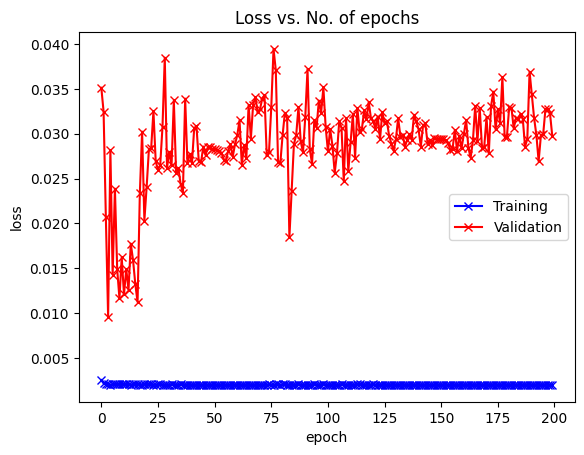

In [17]:
num_epochs = 200  
model_name = "simepleRNN"
dataset = index_list[0]
model = rnn


# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.001)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


rnn_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            model_name,
                            dataset
                            )
plot_loss(rnn_results['train_loss'], rnn_results['val_loss'])

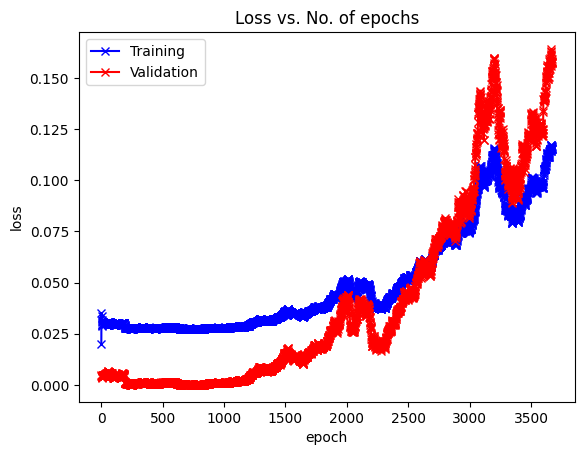

In [22]:
# train_data
# valid_data
# test_data
model_pred = rnn_results['best_model']
outputs, hidden = model_pred(torch.tensor(train_data), None)
outputs = outputs.detach().numpy()
plot_loss(outputs,train_data)

### 6. Evaluation with Testing Set

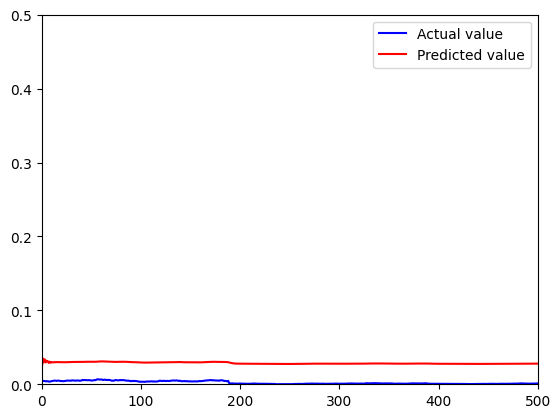

In [19]:
plt.plot(train_data,c='b')
plt.plot(outputs,c='r')
plt.xlim(0,500)
plt.ylim(0,0.5)
plt.legend(["Actual value","Predicted value"])
plt.show()